In [1]:
!pip install sklearn

Basic imports for modeling and plotting data, along with some of the algorithms we're going to use later in data analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.options.display.max_rows = None
pd.options.display.max_columns = None
rewards = 'Rewards_Signup'

First step, was importing the data and doing some basic analysis. I began by looking at the number of values, and unique values per column.

In [3]:
df = pd.read_csv('data/BigRetail_CRM.csv', delimiter=',')
print(df.shape)
print(df.nunique())

(891, 10)
Rewards_Signup        2
Customer_ID         891
Age                  88
Sex                   2
Addtl_HH_size         9
CustomerType          3
LastPurchaseAmt     248
Purchase_Prod_ID    681
CustomerTier          3
CustomerTier2       147
dtype: int64


From this, I came away with two conclusions
- Customer_ID is unique, it's safe to drop it--the id doesn't provide any useful information
- Purchase_Prod_ID is non-unique, which suggests the provided documentation is incorrect. Rather than pointing to a recipt unique to the order, it appears to be pointing to the item being ordered. I confirmed this by spot checking a few values, and saw that the LastPurchaseAmt is the same if the Purchase_Prod_ID matches. Given we know nothing about what these IDs mean, I've opted to drop it from the first analysis. However, if BigRetail is willing to provide us with more information surrounding what these mean, I believe this field could be incredibly useful for future modeling efforts. Ex: We could merge IDs into families of related products (electronics, furniture, food, etc.) which provides a profile of what type of shopper is best targeted for rewards.

Next, I ran a null check over the data.

In [4]:
df.isnull().sum()

Rewards_Signup        0
Customer_ID           0
Age                 177
Sex                   0
Addtl_HH_size         0
CustomerType          2
LastPurchaseAmt       0
Purchase_Prod_ID      0
CustomerTier          0
CustomerTier2       687
dtype: int64

The large number of nulls, means that even if we had visibility into what CustomerTier2 does, we wouldn't be able to effectively leverage it. The nulls in the Age and CustomerType columns are also troubling, as the analysis below shows those both have a definite influence over reward signups. I'll be correcting this as part of prepping the data for analysis.

For data prep, I dropped the three fields mentioned above, set all unprovided Ages to a value of '-1', and unprovided CustomerTypes to 'Unknown'

In [5]:

df = df.drop(['Customer_ID', 'Purchase_Prod_ID', 'CustomerTier2'], axis=1)
df = df.round(2)
df["Age"] = df['Age'].fillna(-1)
df['CustomerType'] = df['CustomerType'].fillna('Unknown')

With the data prepared, began making some basic graphs to see if there were any broad trends in reward signups related to specific variables.

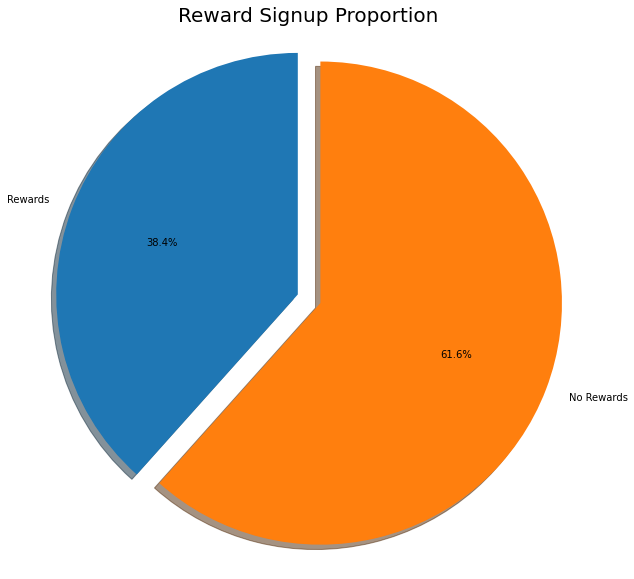

In [6]:
# Total Rewards vs. No Rewards
labels = 'Rewards', 'No Rewards'
sizes = [df.Rewards_Signup[df[rewards] == 1].count(), df.Rewards_Signup[df[rewards] == 0].count()]
fig, axis = plt.subplots(figsize=(10, 10))
axis.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axis.axis('equal')
plt.title("Reward Signup Proportion", size=20)
plt.show()

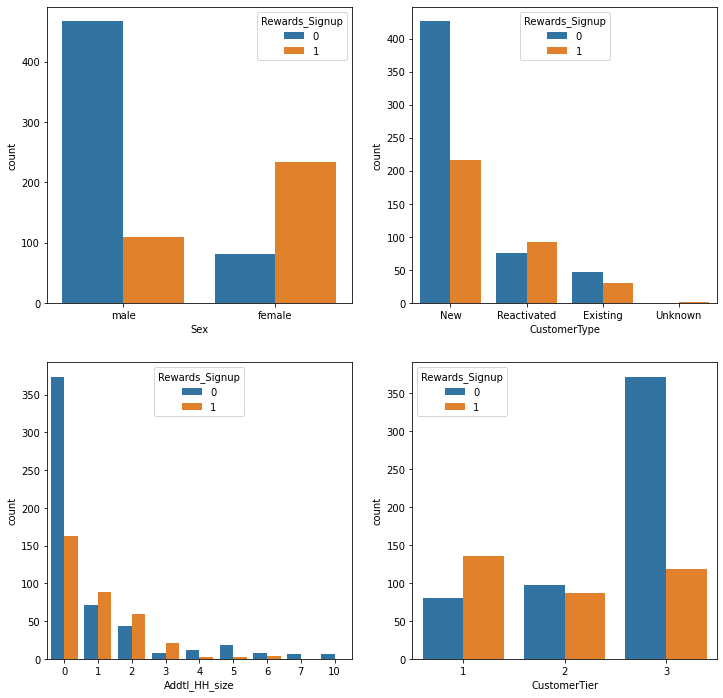

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(12, 12))

# Reward Signup breakdown by Sex
sns.countplot(x='Sex', hue=rewards, data=df, ax=axis[0][0])

# Reward Signup breakdown by Houshold Size
sns.countplot(x='Addtl_HH_size', hue=rewards, data=df, ax=axis[1][0])

# Reward Signup breakdown by CustomerType
sns.countplot(x='CustomerType', hue=rewards, data=df, ax=axis[0][1])

# Reward Signup breakdown by CustomerTier
sns.countplot(x='CustomerTier', hue=rewards, data=df, ax=axis[1][1])
plt.show()

Originally, I had planned on dropping CustomerTier completely, since we have no visibility into the model. However the positive correlation between customer value and signing up for rewards convinced me to include it.

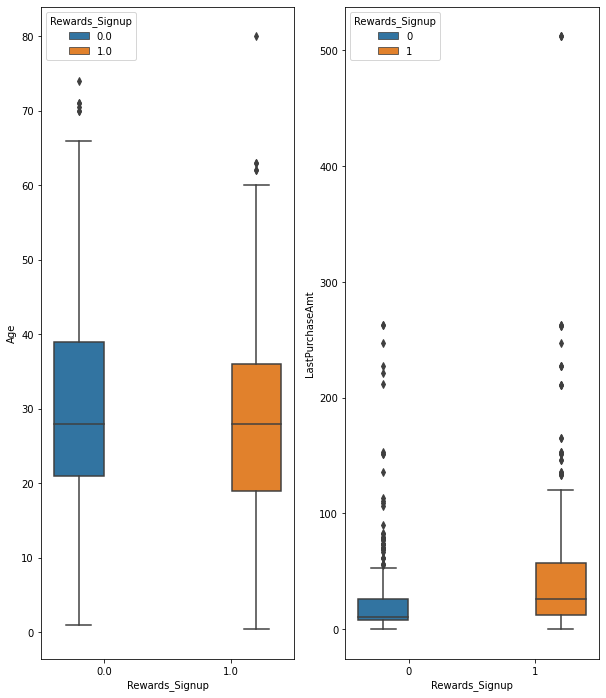

In [8]:
fig, axis = plt.subplots(1, 2, figsize=(10, 12))
sns.boxplot(y='Age', x=rewards, hue=rewards, data=df.where(df['Age'] != -1), ax=axis[0])
sns.boxplot(y='LastPurchaseAmt', x=rewards, hue=rewards, data=df, ax=axis[1])
# Commented out because Jupyter's version of plt can't handle this expression. Image attached below
#sns.countplot(x='Age', hue=rewards, data=df.where(df['Age'] == -1), ax=axis[2])
plt.show()

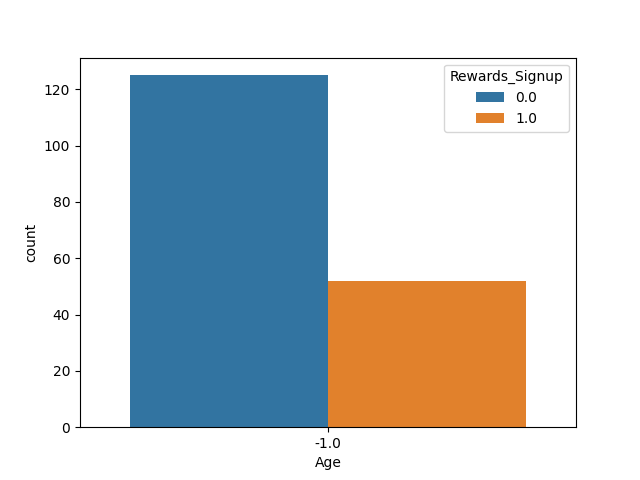

In [22]:
from IPython import display
display.Image("data/reward_signup_no_age_provided.png")

With the basic analysis done, and proving the fields I'd considered do provide some insight into purchase trends, I begain building the training and testing sets.

In [9]:
def model_training(df):
    
    # Ensure we're working within the context of a model, not a view
    df2 = df.copy()
    cont_vars = ['Age', 'LastPurchaseAmt']
    disc_vars = ['Sex', 'CustomerType', 'Addtl_HH_size', 'CustomerTier']
    df2 = df2[[rewards] + cont_vars + disc_vars]

    # Break down some of the discrete variables into 1 column per potential value
    # Setting the column with the appropriate value to 1, and the others to -1
    # Ex: Sex male -> Sex_male 1, Sex_female -1
    replaceable_vars = ['Sex', 'CustomerType', 'CustomerTier']
    rm = list()
    for i in replaceable_vars:
        for j in df2[i].unique():
            if pd.notna(j):
                df2[str(i) + '_' + str(j)] = np.where(df2[i] == j, 1, -1)
        rm.append(i)
    df2 = df2.drop(rm, axis=1)

    # Once we've done the pre-processing, then break it down into train and predict sets
    df_train = df2.sample(frac=0.85, random_state=np.random.RandomState()).copy()
    df_predict = df2.drop(df_train.index).copy()
    min_vector = df_train[cont_vars].min().copy()
    max_vector = df_train[cont_vars].max().copy()
    df_train[cont_vars] = (df_train[cont_vars] - min_vector) / (max_vector - min_vector)

    df_predict = process_testing_data(df_predict, df_train.columns, min_vector, max_vector)
    return df_train, df_predict


def process_testing_data(df_predict, df_train_columns, min_vector, max_vector):
    cont_vars = ['Age', 'LastPurchaseAmt']
    df_predict_columns = list(set(df_train_columns) - set(df_predict.columns))
    for k in df_predict_columns:
        df_predict[str(k)] = -1
    df_predict[cont_vars] = (df_predict[cont_vars] - min_vector) / (max_vector - min_vector)
    return df_predict[df_train_columns]

df_train, df_predict = model_training(df)

Next, I ran various algorithms, to determine which one best modeled the data. Going one step further, I used a grid search function to test various parameter combinations to find the best fit for the data set.

In [10]:
# Poly2 Logistic Regression
param_grid_space = {
    'C': [0.1, 1.0, 10, 50],
    'max_iter': [100, 300, 500],
    'tol': [0.0001, 0.000001]
}
poly2 = PolynomialFeatures()
df_poly2 = poly2.fit_transform(df_train.loc[:, df_train.columns != rewards])
poly2_grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_space)
poly2_grid.fit(df_poly2, df_train[rewards])
print(poly2_grid.best_score_)
print(poly2_grid.best_params_)

0.8228999651446497
{'C': 10, 'max_iter': 100, 'tol': 0.0001}


In [11]:
# RBF SVC

param_grid_space = {
    'C': [0.5, 100, 150],
    'gamma': [0.1, 0.01, 0.001],
    'probability': [True]
}
svm_grid = GridSearchCV(SVC(), param_grid=param_grid_space, cv=3)
svm_grid.fit(df_train.loc[:, df_train.columns != rewards], df_train[rewards])
print(svm_grid.best_score_)
print(svm_grid.best_params_)

0.8137064224020746
{'C': 100, 'gamma': 0.01, 'probability': True}


In [12]:
# Polynomical SVC

param_grid_space = {
    'C': [0.5, 1, 10, 50, 100],
    'gamma': [0.1, 0.01, 0.001],
    'probability': [True],
    'kernel': ['poly'],
    'degree': [2, 3]
}
svm_grid = GridSearchCV(SVC(), param_grid=param_grid_space, cv=3)
svm_grid.fit(df_train.loc[:, df_train.columns != rewards], df_train[rewards])
print(svm_grid.best_score_)
print(svm_grid.best_params_)

0.8176746763703285
{'C': 50, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}


In [13]:
# Random Forest
param_grid_space = {
    'max_depth': [5, 6, 7, 8],
    'max_features': [8, 9, 10, 11],
    'n_estimators': [50, 100],
    'min_samples_split': [4, 5, 6, 7]
}
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_space)
forest_grid.fit(df_train.loc[:, df_train.columns != rewards], df_train[rewards])
print(forest_grid.best_score_)
print(forest_grid.best_params_)

0.8387155803415824
{'max_depth': 7, 'max_features': 11, 'min_samples_split': 7, 'n_estimators': 50}


With a score of 0.839, Random Forest proves to be the best algorithm, and the one I'll go forward with

In [14]:
# Function to calculate auc scores, this'll be necessary to make the curves
def get_auc_scores(score_column_name, predict, predict_probability):
    auc_score = roc_auc_score(score_column_name, predict)
    fpr_df, tpr_df, _ = roc_curve(score_column_name, predict_probability)
    return auc_score, fpr_df, tpr_df

Using the results of the optimization tests, I instantiated a new RF classifier, ran it over the training set, and put together a classification report. With high precision in detecting both positives and negatives, this is the algorithm and parameters I'm going to stick with.

In [18]:
# Pulled from results of the forest test
optimal_model_params = {'max_depth': 7, 'max_features': 11, 'min_samples_split': 7, 'n_estimators': 50}

forest = RandomForestClassifier(max_depth=optimal_model_params['max_depth'],
                                    max_features=optimal_model_params['max_features'],
                                    n_estimators=optimal_model_params['n_estimators'],
                                    min_samples_split=optimal_model_params['min_samples_split'])
forest.fit(df_train.loc[:, df_train.columns != rewards], df_train[rewards])
forest_prediction_score = forest.predict(df_train.loc[:, df_train.columns != rewards])

print(classification_report(df_train[rewards], forest_prediction_score))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       474
           1       0.93      0.77      0.85       283

    accuracy                           0.89       757
   macro avg       0.90      0.87      0.88       757
weighted avg       0.90      0.89      0.89       757



A visual representation of the classification report information

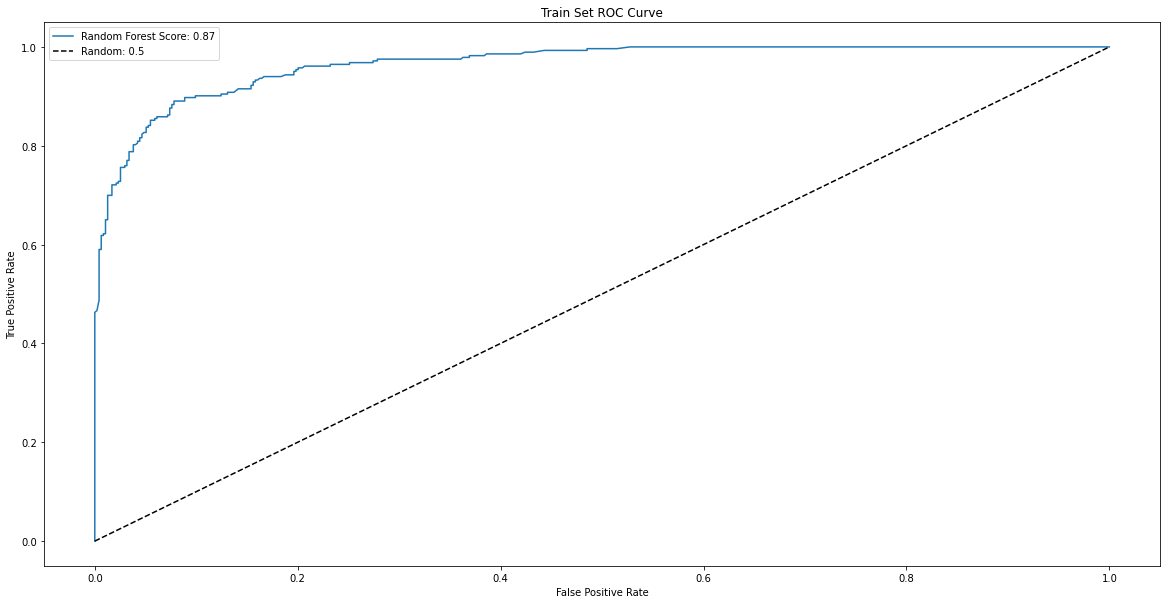

In [19]:
auc_forest, fpr_forest, tpr_forest = get_auc_scores(
    df_train[rewards],
    forest_prediction_score,
    forest.predict_proba(df_train.loc[:, df_train.columns != rewards])[:, 1]
)
plt.figure(figsize=(20, 10), linewidth=1)
plt.plot(fpr_forest, tpr_forest, label="Random Forest Score: " + str(round(auc_forest, 3)))
plt.plot([0, 1], [0, 1], 'k--', label="Random: 0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train Set ROC Curve")
plt.legend(loc='best')
plt.show()

Visual representation of the final run over the predict set that was partitioned off when we were prepping data.

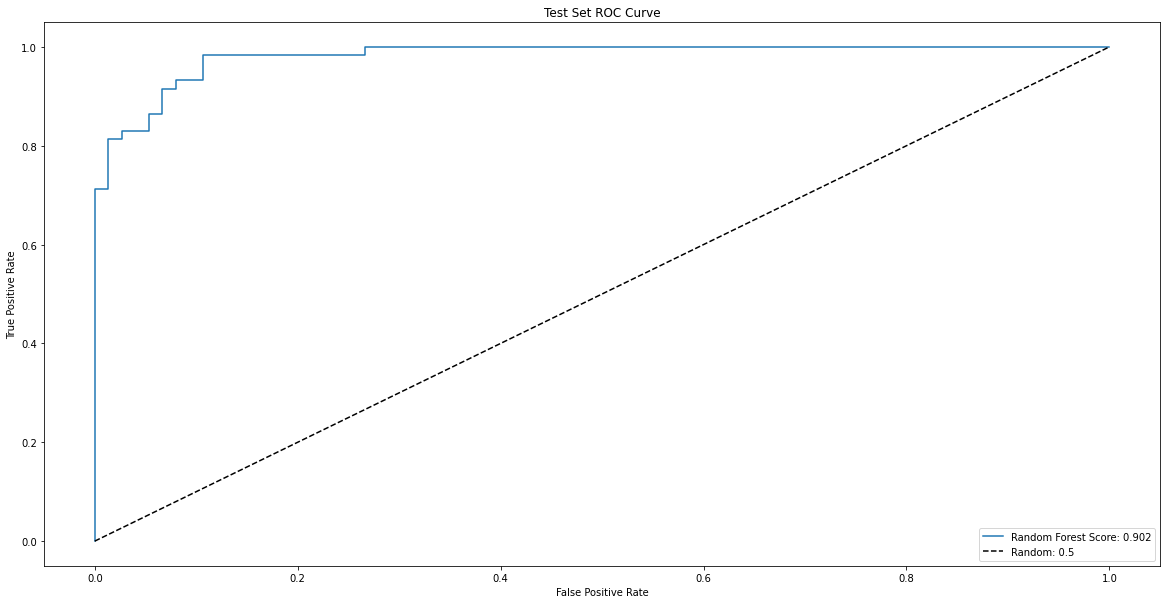

In [20]:
forest.fit(df_predict.loc[:, df_predict.columns != rewards], df_predict[rewards])
auc_forest, fpr_forest, tpr_forest = get_auc_scores(
    df_predict.Rewards_Signup,
    forest.predict(df_predict.loc[:, df_predict.columns != rewards]),
    forest.predict_proba(df_predict.loc[:, df_predict.columns != rewards])[:, 1]
)

plt.figure(figsize=(20, 10), linewidth=1)
plt.plot(fpr_forest, tpr_forest, label="Random Forest Score: " + str(round(auc_forest, 3)))
plt.plot([0, 1], [0, 1], 'k--', label="Random: 0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set ROC Curve")
plt.legend(loc='best')
plt.show()